In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import pylab as plt

import sys
#sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/')
sys.path.append('/data/id01/inhouse/bouita/P10_analysis/EB_modules/')
from Reconstruction import *
from Plot_utilities import *
from Global_utilities import *

from Reconstruction_crop_algo import *

from Plot_utilities import *
from Object_utilities import *
from PostProcessing import *

from Orthogonalization_real_space import *
from StrainTiltCalculation import *

from CreateVTI import *

In [2]:
# # Load individual arrays
# F_T = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results/F_T_3d.npy")['data']
# F_A = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results/F_A_3d.npy")['data']
# F_N = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results/F_N_3d.npy")['data']
# delta_phi = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results/delta_phi_3d.npz")['data']

In [3]:
# Correct path and loading
base_path = "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD_ML/Phase7/inference_output_v5_fa_fix/"

F_T = np.load(base_path + "F_T_3d.npy")
F_A = np.load(base_path + "F_A_3d.npy")
F_N = np.load(base_path + "F_N_3d.npy")
delta_phi = np.load(base_path + "delta_phi_3d.npy")

print(f"F_T shape: {F_T.shape}")
print(f"F_A shape: {F_A.shape}")
print(f"F_N shape: {F_N.shape}")
print(f"delta_phi shape: {delta_phi.shape}")

F_T shape: (128, 128, 128)
F_A shape: (128, 128, 128)
F_N shape: (128, 128, 128)
delta_phi shape: (128, 128, 128)


In [3]:
# =============================================================================
# EXTERNAL SUPPORT INJECTION
# Add this cell in the NanoMAD reconstruction notebook, BEFORE CDI initialization
# =============================================================================

import numpy as np
from numpy.fft import fftshift

# -----------------------------------------------------------------------------
# 1. Load the clean support from simulation
# -----------------------------------------------------------------------------
support_path_FA = "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/support_FA.npy"
clean_support_FA = np.load(support_path_FA)

support_path_FN = "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/support_FN.npy"
clean_support_FN = np.load(support_path_FN)

support_path_FT = "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/support_FT.npy"
clean_support_FT = np.load(support_path_FT)

print(f"Loaded FA support shape: {clean_support_FA.shape}")
print(f"FA support voxels: {clean_support_FA.sum():.0f}")

print(f"Loaded FN support shape: {clean_support_FN.shape}")
print(f"FN support voxels: {clean_support_FN.sum():.0f}")

print(f"Loaded FT support shape: {clean_support_FT.shape}")
print(f"FT support voxels: {clean_support_FT.sum():.0f}")

""""Probably don't need to rotate since it's from FA, FN, FT"""
# -----------------------------------------------------------------------------
# 2. Apply coordinate rotation to match NanoMAD data frame
# -----------------------------------------------------------------------------
# The notebook applies this to data: np.rot90(data, 1, (1, 2))
# We must apply the SAME rotation to the support

# clean_support = np.ascontiguousarray(np.rot90(clean_support, 1, (1, 2)))

# print(f"After rotation - shape: {clean_support.shape}")

# -----------------------------------------------------------------------------
# 3. Verify shape matches your data
# -----------------------------------------------------------------------------
# Uncomment and modify these checks based on your data variable names:
# assert clean_support.shape == data_new_FA.shape, \
#     f"Shape mismatch! Support: {clean_support.shape}, Data: {data_new_FA.shape}"

Loaded FA support shape: (128, 128, 128)
FA support voxels: 42689
Loaded FN support shape: (128, 128, 128)
FN support voxels: 18104
Loaded FT support shape: (128, 128, 128)
FT support voxels: 43087


'"Probably don\'t need to rotate since it\'s from FA, FN, FT'

MAD PARAMETER ARRAYS - VERIFICATION (3D)

1. SHAPE AND DTYPE
----------------------------------------
  F_T         : shape=(128, 128, 128), dtype=float32
  F_A         : shape=(128, 128, 128), dtype=float32
  F_N         : shape=(128, 128, 128), dtype=float32
  delta_phi   : shape=(128, 128, 128), dtype=float32

2. VALUE STATISTICS
----------------------------------------
  F_T         : min=      0.0000, max=  75879.4219, mean=     73.2464
  F_A         : min=      0.0000, max=   3853.5212, mean=     33.3297
  F_N         : min=      0.0000, max=  74612.9062, mean=     43.6381
  delta_phi   : min=     -3.1412, max=      3.1412, mean=     -0.0070

3. SANITY CHECKS
----------------------------------------
  F_T all >= 0: True
  F_A all >= 0: True
  F_N all >= 0: True
  delta_phi in [-π, π]: True
  F_N matches law of cosines: True


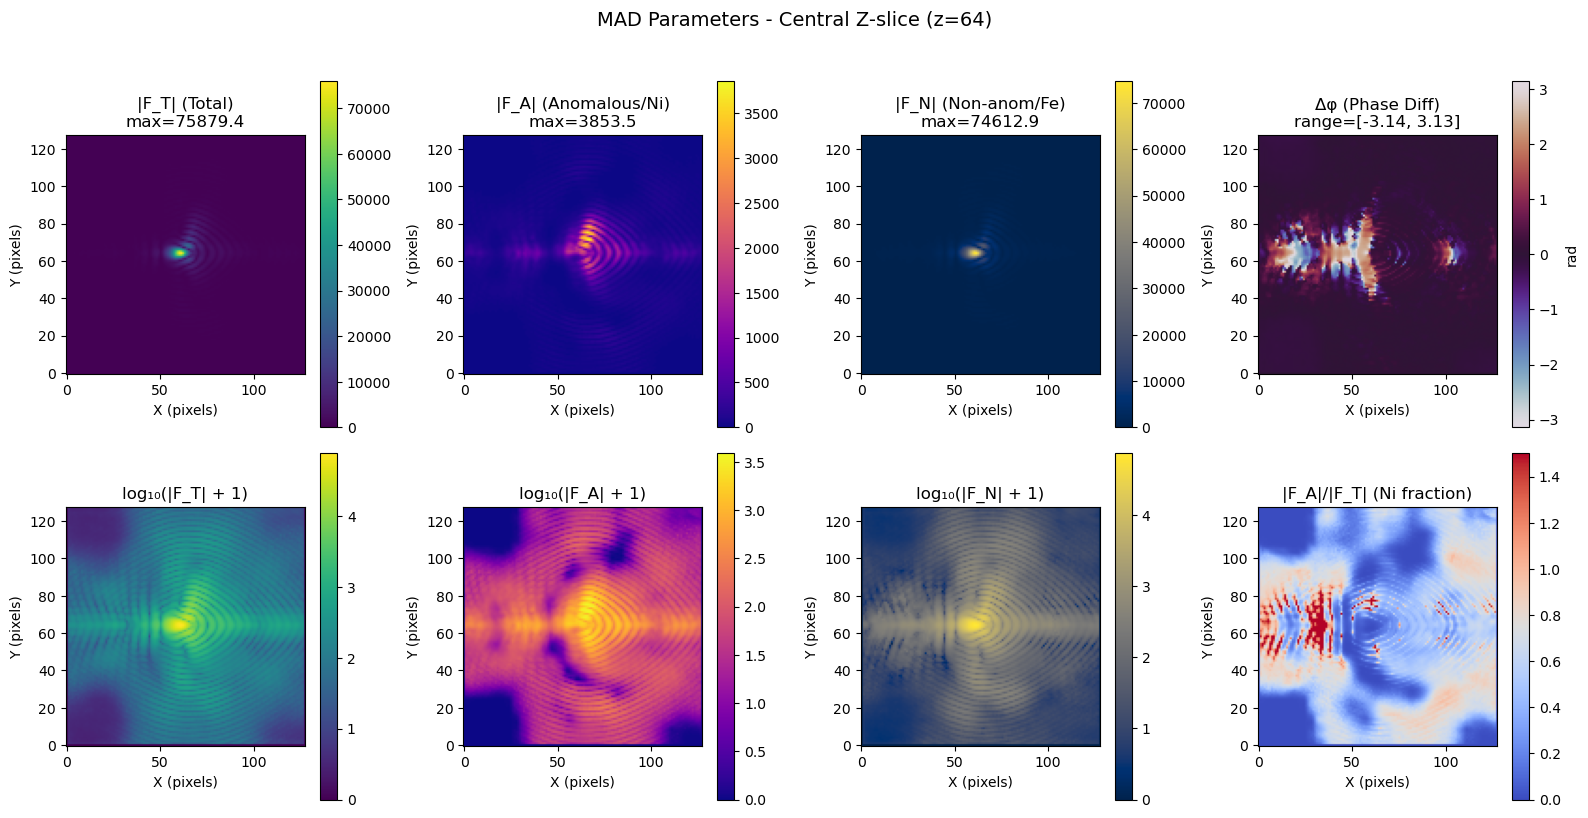

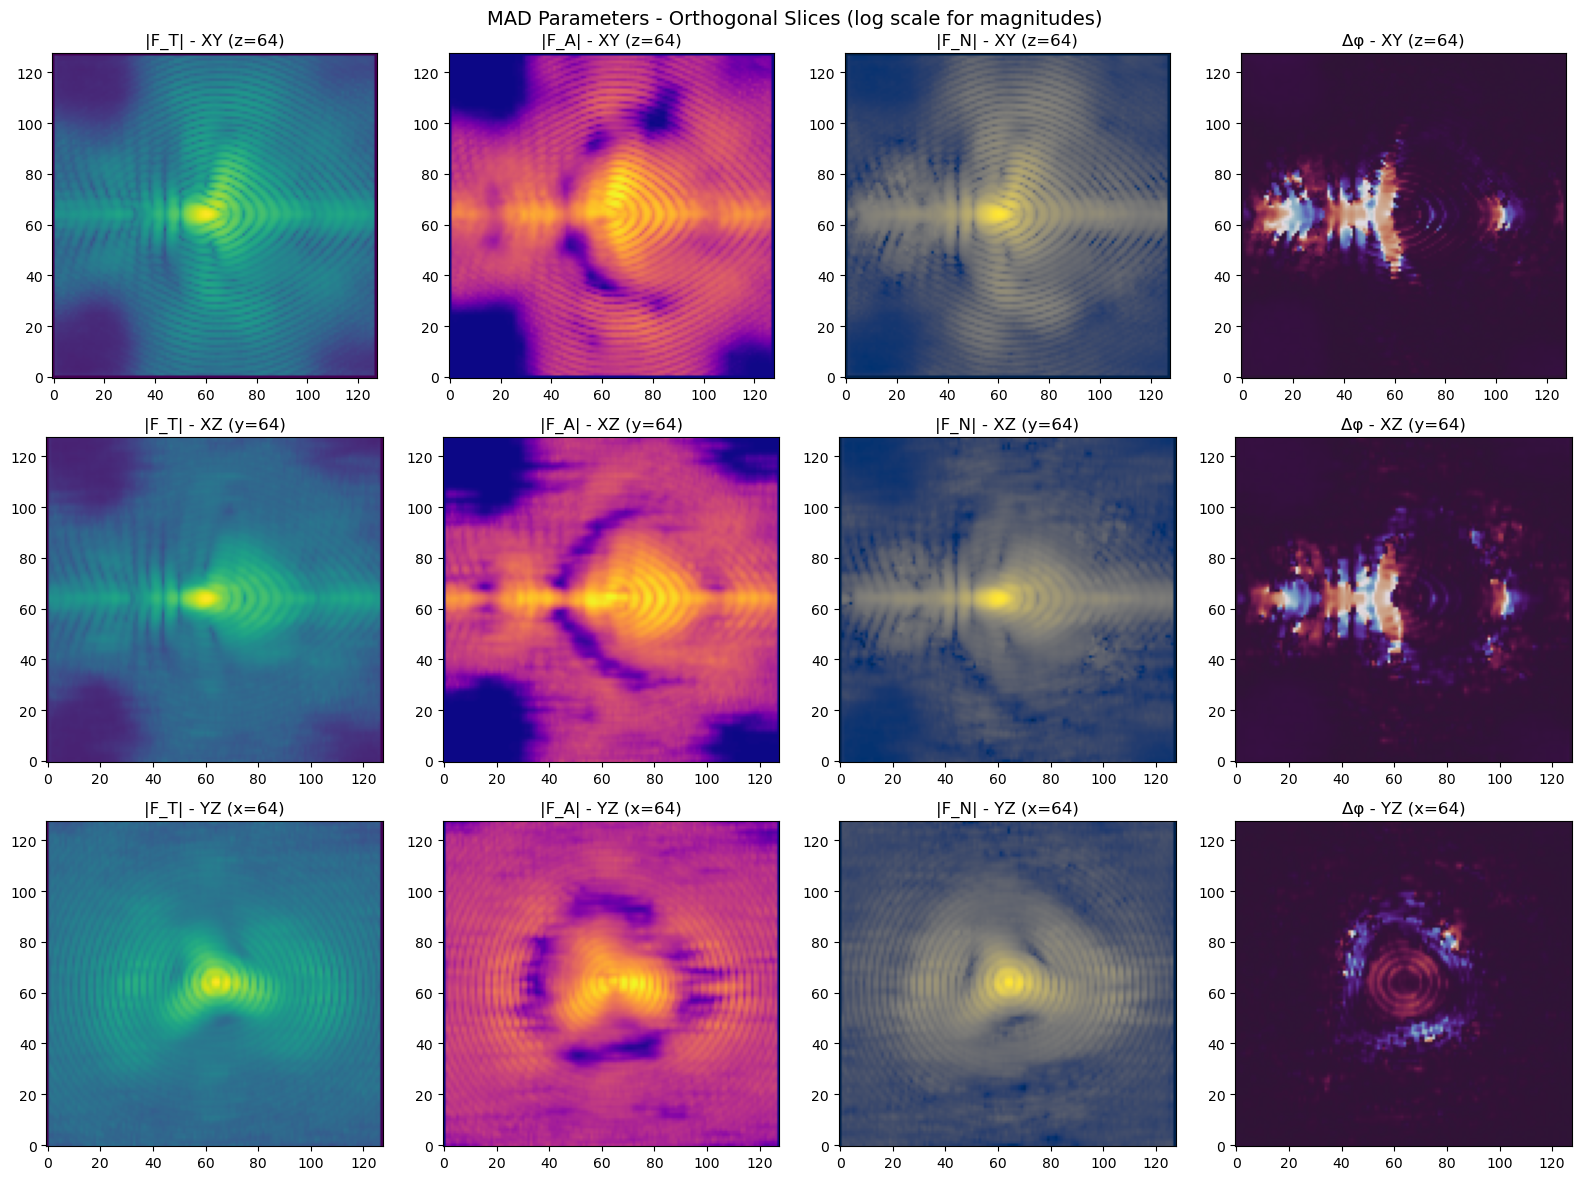

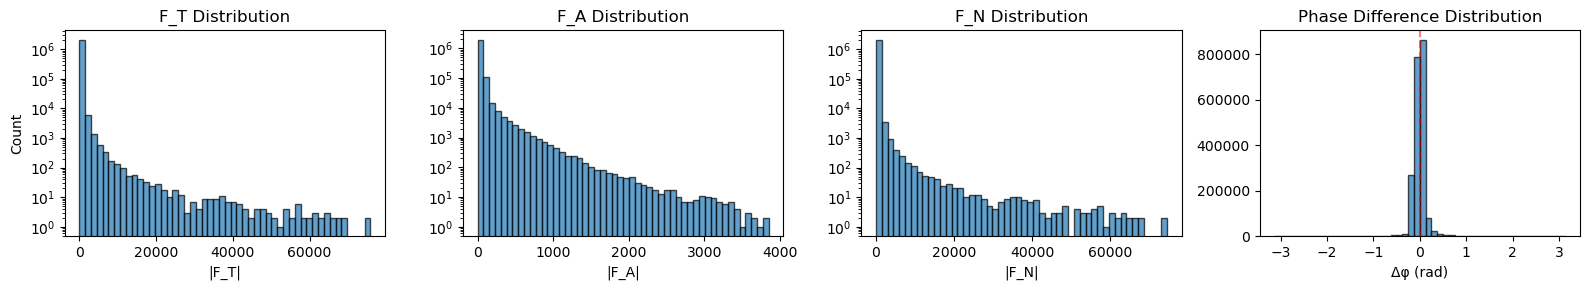


✓ 3D Data verified and visualized!


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# VERIFY LOADED MAD PARAMETERS (3D VERSION)
# =============================================================================

print("=" * 60)
print("MAD PARAMETER ARRAYS - VERIFICATION (3D)")
print("=" * 60)

# Basic info
arrays = {'F_T': F_T, 'F_A': F_A, 'F_N': F_N, 'delta_phi': delta_phi}

print("\n1. SHAPE AND DTYPE")
print("-" * 40)
for name, arr in arrays.items():
    print(f"  {name:12s}: shape={arr.shape}, dtype={arr.dtype}")

print("\n2. VALUE STATISTICS")
print("-" * 40)
for name, arr in arrays.items():
    print(f"  {name:12s}: min={arr.min():12.4f}, max={arr.max():12.4f}, mean={arr.mean():12.4f}")

print("\n3. SANITY CHECKS")
print("-" * 40)
print(f"  F_T all >= 0: {(F_T >= 0).all()}")
print(f"  F_A all >= 0: {(F_A >= 0).all()}")
print(f"  F_N all >= 0: {(F_N >= 0).all()}")
print(f"  delta_phi in [-π, π]: {(delta_phi >= -np.pi).all() and (delta_phi <= np.pi).all()}")

# Check F_N computation: |F_N|² = |F_T|² + |F_A|² - 2|F_T||F_A|cos(Δφ)
with np.errstate(invalid='ignore'):
    F_N_sq_check = F_T**2 + F_A**2 - 2*F_T*F_A*np.cos(delta_phi)
    F_N_sq_check = np.maximum(F_N_sq_check, 0)  # Clamp negative values
    F_N_check = np.sqrt(F_N_sq_check)
    F_N_match = np.allclose(F_N, F_N_check, rtol=1e-3, equal_nan=True)
print(f"  F_N matches law of cosines: {F_N_match}")

print("=" * 60)

# =============================================================================
# VISUALIZATION - CENTRAL SLICES
# =============================================================================

# Extract central slices
z_center = F_T.shape[0] // 2
y_center = F_T.shape[1] // 2
x_center = F_T.shape[2] // 2

# Get 2D slices
F_T_z = F_T[z_center, :, :]  # XY plane
F_A_z = F_A[z_center, :, :]
F_N_z = F_N[z_center, :, :]
dphi_z = delta_phi[z_center, :, :]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: Linear scale
im0 = axes[0, 0].imshow(F_T_z, cmap='viridis', origin='lower')
axes[0, 0].set_title(f'|F_T| (Total)\nmax={F_T_z.max():.1f}')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(F_A_z, cmap='plasma', origin='lower')
axes[0, 1].set_title(f'|F_A| (Anomalous/Ni)\nmax={F_A_z.max():.1f}')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(F_N_z, cmap='cividis', origin='lower')
axes[0, 2].set_title(f'|F_N| (Non-anom/Fe)\nmax={F_N_z.max():.1f}')
plt.colorbar(im2, ax=axes[0, 2])

im3 = axes[0, 3].imshow(dphi_z, cmap='twilight', vmin=-np.pi, vmax=np.pi, origin='lower')
axes[0, 3].set_title(f'Δφ (Phase Diff)\nrange=[{dphi_z.min():.2f}, {dphi_z.max():.2f}]')
plt.colorbar(im3, ax=axes[0, 3], label='rad')

# Bottom row: Log scale for magnitudes, ratio for comparison
im4 = axes[1, 0].imshow(np.log10(F_T_z + 1), cmap='viridis', origin='lower')
axes[1, 0].set_title('log₁₀(|F_T| + 1)')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(np.log10(F_A_z + 1), cmap='plasma', origin='lower')
axes[1, 1].set_title('log₁₀(|F_A| + 1)')
plt.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(np.log10(F_N_z + 1), cmap='cividis', origin='lower')
axes[1, 2].set_title('log₁₀(|F_N| + 1)')
plt.colorbar(im6, ax=axes[1, 2])

# F_A / F_T ratio (Ni fraction)
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = F_A_z / (F_T_z + 1e-10)
    ratio = np.clip(ratio, 0, 2)
im7 = axes[1, 3].imshow(ratio, cmap='coolwarm', vmin=0, vmax=1.5, origin='lower')
axes[1, 3].set_title('|F_A|/|F_T| (Ni fraction)')
plt.colorbar(im7, ax=axes[1, 3])

for ax in axes.flat:
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')

plt.suptitle(f'MAD Parameters - Central Z-slice (z={z_center})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# =============================================================================
# ORTHOGONAL VIEWS (XY, XZ, YZ planes)
# =============================================================================

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Row 0: XY plane (z=center)
axes[0, 0].imshow(np.log10(F_T[z_center, :, :] + 1), cmap='viridis', origin='lower')
axes[0, 0].set_title(f'|F_T| - XY (z={z_center})')
axes[0, 1].imshow(np.log10(F_A[z_center, :, :] + 1), cmap='plasma', origin='lower')
axes[0, 1].set_title(f'|F_A| - XY (z={z_center})')
axes[0, 2].imshow(np.log10(F_N[z_center, :, :] + 1), cmap='cividis', origin='lower')
axes[0, 2].set_title(f'|F_N| - XY (z={z_center})')
axes[0, 3].imshow(delta_phi[z_center, :, :], cmap='twilight', vmin=-np.pi, vmax=np.pi, origin='lower')
axes[0, 3].set_title(f'Δφ - XY (z={z_center})')

# Row 1: XZ plane (y=center)
axes[1, 0].imshow(np.log10(F_T[:, y_center, :] + 1), cmap='viridis', origin='lower', aspect='auto')
axes[1, 0].set_title(f'|F_T| - XZ (y={y_center})')
axes[1, 1].imshow(np.log10(F_A[:, y_center, :] + 1), cmap='plasma', origin='lower', aspect='auto')
axes[1, 1].set_title(f'|F_A| - XZ (y={y_center})')
axes[1, 2].imshow(np.log10(F_N[:, y_center, :] + 1), cmap='cividis', origin='lower', aspect='auto')
axes[1, 2].set_title(f'|F_N| - XZ (y={y_center})')
axes[1, 3].imshow(delta_phi[:, y_center, :], cmap='twilight', vmin=-np.pi, vmax=np.pi, origin='lower', aspect='auto')
axes[1, 3].set_title(f'Δφ - XZ (y={y_center})')

# Row 2: YZ plane (x=center)
axes[2, 0].imshow(np.log10(F_T[:, :, x_center] + 1), cmap='viridis', origin='lower', aspect='auto')
axes[2, 0].set_title(f'|F_T| - YZ (x={x_center})')
axes[2, 1].imshow(np.log10(F_A[:, :, x_center] + 1), cmap='plasma', origin='lower', aspect='auto')
axes[2, 1].set_title(f'|F_A| - YZ (x={x_center})')
axes[2, 2].imshow(np.log10(F_N[:, :, x_center] + 1), cmap='cividis', origin='lower', aspect='auto')
axes[2, 2].set_title(f'|F_N| - YZ (x={x_center})')
axes[2, 3].imshow(delta_phi[:, :, x_center], cmap='twilight', vmin=-np.pi, vmax=np.pi, origin='lower', aspect='auto')
axes[2, 3].set_title(f'Δφ - YZ (x={x_center})')

plt.suptitle('MAD Parameters - Orthogonal Slices (log scale for magnitudes)', fontsize=14)
plt.tight_layout()
plt.show()

# =============================================================================
# HISTOGRAMS
# =============================================================================

fig, axes = plt.subplots(1, 4, figsize=(16, 3))

axes[0].hist(F_T.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('|F_T|')
axes[0].set_ylabel('Count')
axes[0].set_title('F_T Distribution')
axes[0].set_yscale('log')

axes[1].hist(F_A.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('|F_A|')
axes[1].set_title('F_A Distribution')
axes[1].set_yscale('log')

axes[2].hist(F_N.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('|F_N|')
axes[2].set_title('F_N Distribution')
axes[2].set_yscale('log')

axes[3].hist(delta_phi.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[3].axvline(0, color='r', linestyle='--', alpha=0.5)
axes[3].set_xlabel('Δφ (rad)')
axes[3].set_title('Phase Difference Distribution')

plt.tight_layout()
plt.show()

print("\n✓ 3D Data verified and visualized!")

# Anomalous Factors

In [8]:
I_A = np.abs(F_A)**2
I_N = np.abs(F_N)**2
I_T = np.abs(F_T)**2 

In [12]:
# fact = detector_data[..., 5]
fact_FA = detector_data[..., 5]
fact_FN = detector_data[..., 7]
fact_FT = detector_data[..., 3]

# -------------------------------------------------------------------------
# Optional step: replace non-positive values with a small positive constant
# Uncomment if you want to enforce strictly positive values before squaring
fact_FA = np.where(fact_FA <= 0, 1e-6, fact_FA)
fact_FN = np.where(fact_FN <= 0, 1e-6, fact_FN)
fact_FT = np.where(fact_FT <= 0, 1e-6, fact_FT)
# -------------------------------------------------------------------------

# data_new = abs(fact)**2 
data_new_FA = abs(fact_FA)**2 
data_new_FN = abs(fact_FN)**2
data_new_FT = abs(fact_FT)**2

In [13]:
%pwd

'/gpfs/easy/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper'

In [6]:
# noise_label = "pf1e6"
# filedir = f'/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/chunks/HKLMAD_sim_big_particle_noise_{noise_label}__100chunks__nonneg/'
# filename =  f'FTFAFNDPHI_sim_big_particle_noise_{noise_label}.dat'

noise_label = "pf1e6"
# Specify your save directory
save_dir = Path(f'/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results_overlap_500/treated/')  # Change this to your desired directory
save_dir.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

# Define individual file paths
file_FA = save_dir / "reassembled_FA_intensity_noise_pf1e6.npy"
file_FN = save_dir / "reassembled_FN_intensity_noise_pf1e6.npy"
file_FT = save_dir / "reassembled_FT_intensity_noise_pf1e6.npy"

# Save each array only if its file doesn't exist
if not file_FA.exists():
    I_A = abs(F_A)**2
    np.save(file_FA, I_A)
    print(f"Saved {file_FA}")
    print(f"Shape I_A = {np.shape(I_A)}")
else:
    print(f"Skipping {file_FA.name} - already exists")
    print(f"Shape I_A = {np.shape(I_A)}")

if not file_FN.exists():
    I_N = abs(F_N)**2
    np.save(file_FN, I_N)
    print(f"Saved {file_FN}")
    print(f"Shape I_N = {np.shape(I_N)}")
else:
    print(f"Skipping {file_FN.name} - already exists")
    print(f"Shape I_N = {np.shape(I_N)}")

if not file_FT.exists():
    I_T = abs(F_T)**2
    np.save(file_FT, I_T)
    print(f"Saved {file_FT}")
    print(f"Shape I_T = {np.shape(I_T)}")
else:
    print(f"Skipping {file_FT.name} - already exists")
    print(f"Shape I_T = {np.shape(I_T)}")

Saved /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results_overlap_500/treated/reassembled_FA_intensity_noise_pf1e6.npy
Shape I_A = (128, 128, 128)
Saved /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results_overlap_500/treated/reassembled_FN_intensity_noise_pf1e6.npy
Shape I_N = (128, 128, 128)
Saved /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/test_3d_noise_pf1e6_v2/results_overlap_500/treated/reassembled_FT_intensity_noise_pf1e6.npy
Shape I_T = (128, 128, 128)


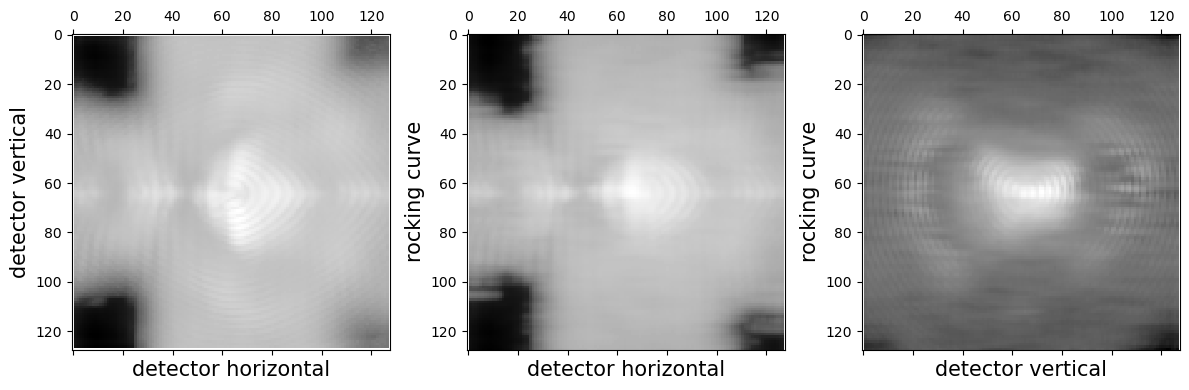

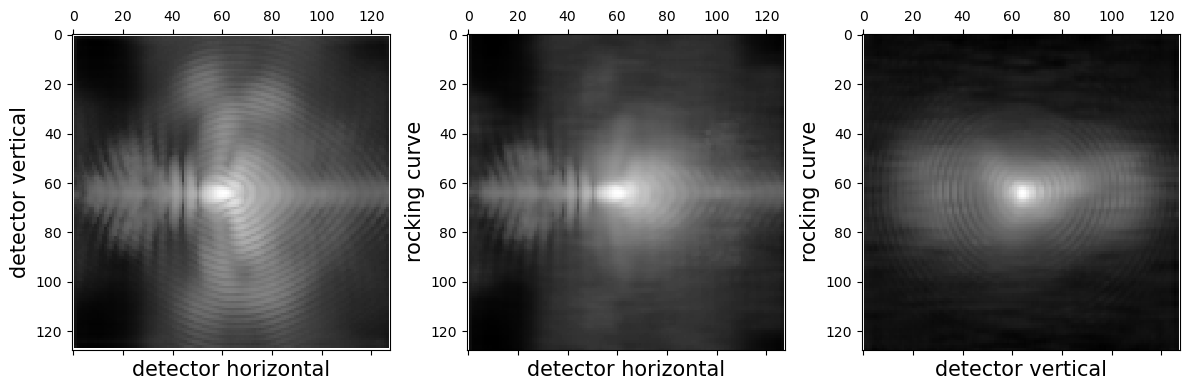

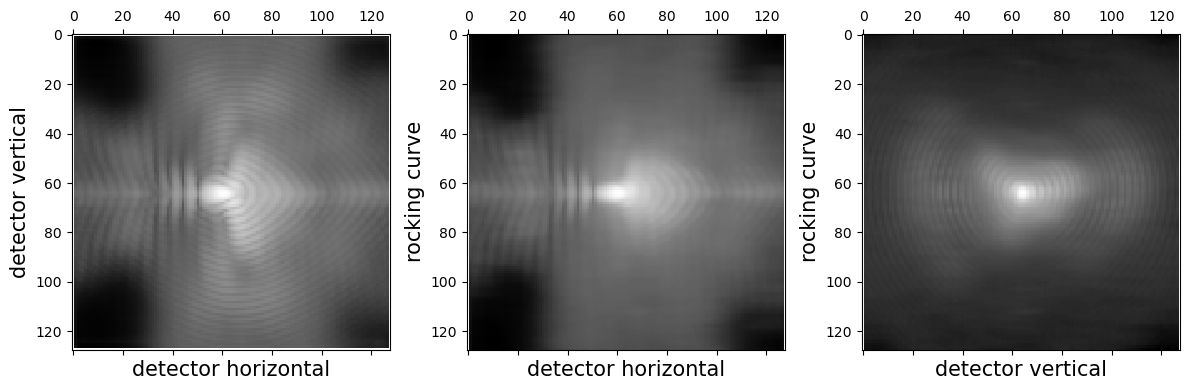

In [6]:
plot_3D_projections(I_A, cmap='gray', axes_labels=True)
plot_3D_projections(I_N, cmap='gray', axes_labels=True)
plot_3D_projections(I_T, cmap='gray', axes_labels=True)

In [14]:
# data_new = np.ascontiguousarray(np.rot90(data_new, 1, (1,2)))
data_new_FA = np.ascontiguousarray(np.rot90(data_new_FA, 1, (1,2)))
data_new_FN = np.ascontiguousarray(np.rot90(data_new_FN, 1, (1,2)))
data_new_FT = np.ascontiguousarray(np.rot90(data_new_FT, 1, (1,2)))

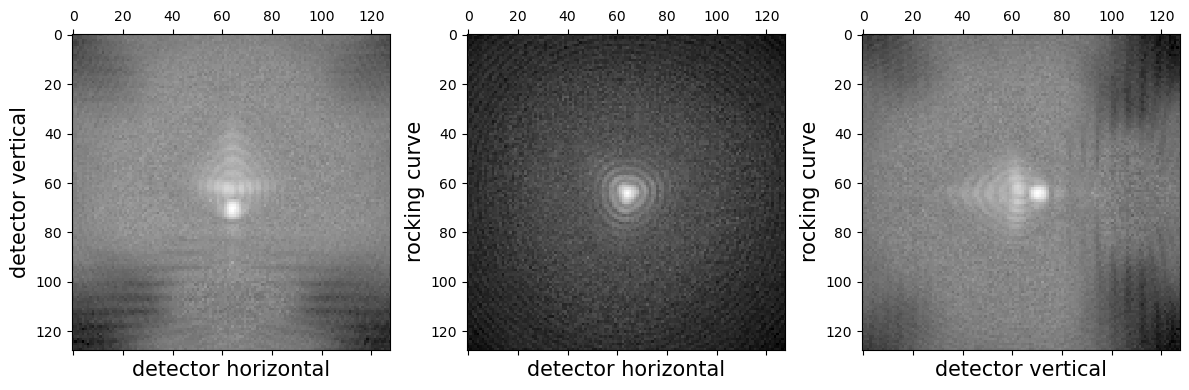

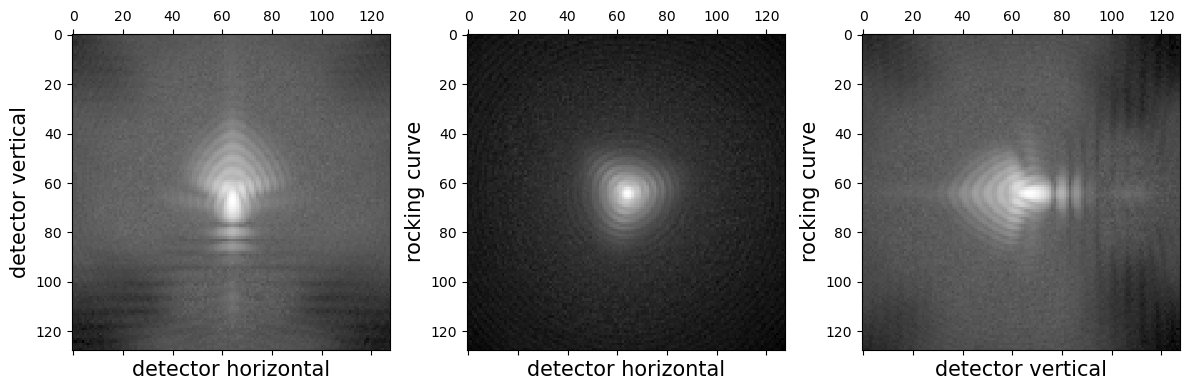

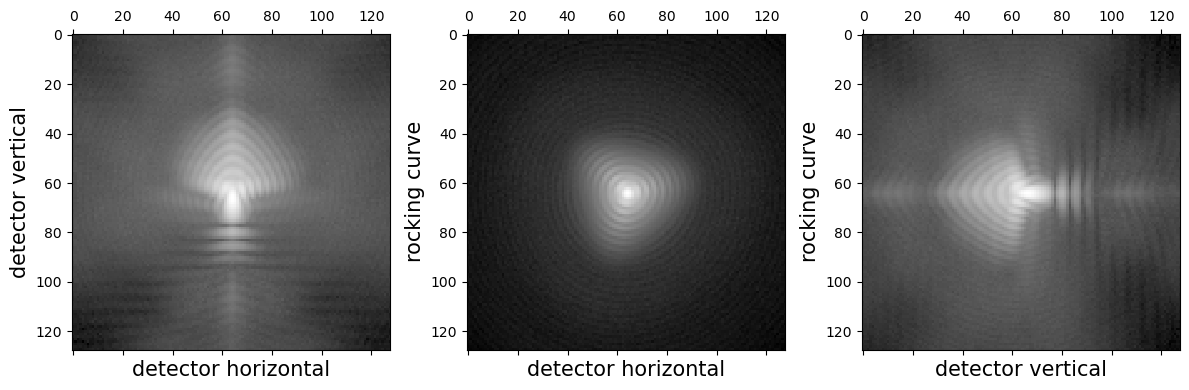

In [15]:
plot_3D_projections(data_new_FA, cmap='gray', axes_labels=True)
plot_3D_projections(data_new_FN, cmap='gray', axes_labels=True)
plot_3D_projections(data_new_FT, cmap='gray', axes_labels=True)


PHASE RETRIEVAL - HIO + SHRINKWRAP
Iterations: 500
HIO beta: 0.9
Shrinkwrap every: 20 iterations
Shrinkwrap sigma: 3.0 → 1.0
Shrinkwrap threshold: 0.1

Starting iterations...
  Iter   50: R = 0.1454, Support = 35.4%
  Iter  100: R = 0.1035, Support = 37.9%
  Iter  150: R = 0.1052, Support = 40.4%
  Iter  200: R = 0.0914, Support = 37.3%
  Iter  250: R = 0.1150, Support = 39.8%
  Iter  300: R = 0.1150, Support = 35.6%
  Iter  350: R = 0.1287, Support = 35.7%
  Iter  400: R = 0.1341, Support = 30.3%
  Iter  450: R = 0.1576, Support = 28.4%
  Iter  500: R = 0.1750, Support = 9.3%

✓ Phase retrieval complete!

Final R-factor: 0.1750
Final support fraction: 9.3%


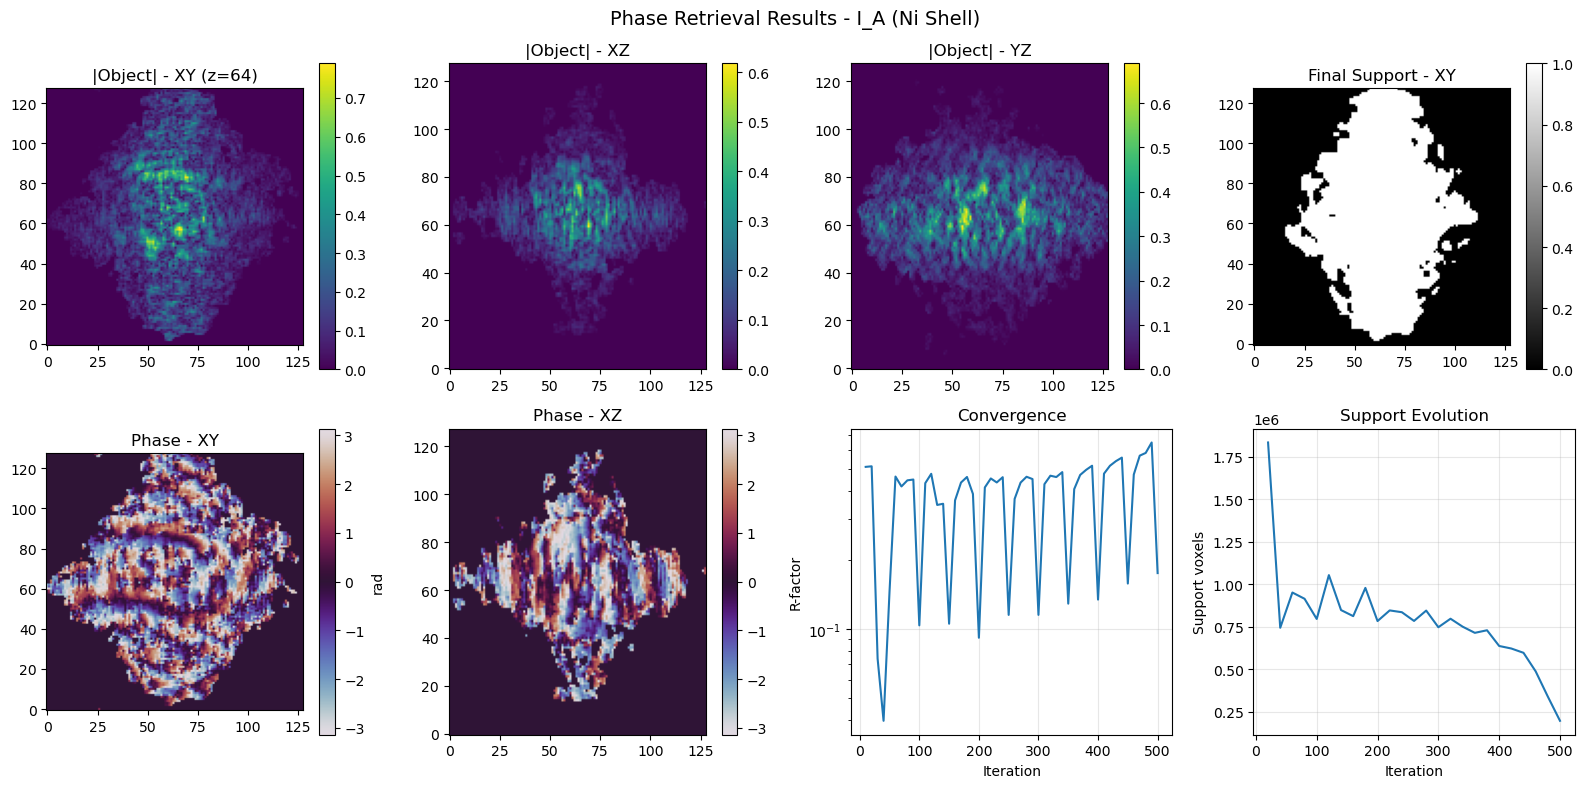

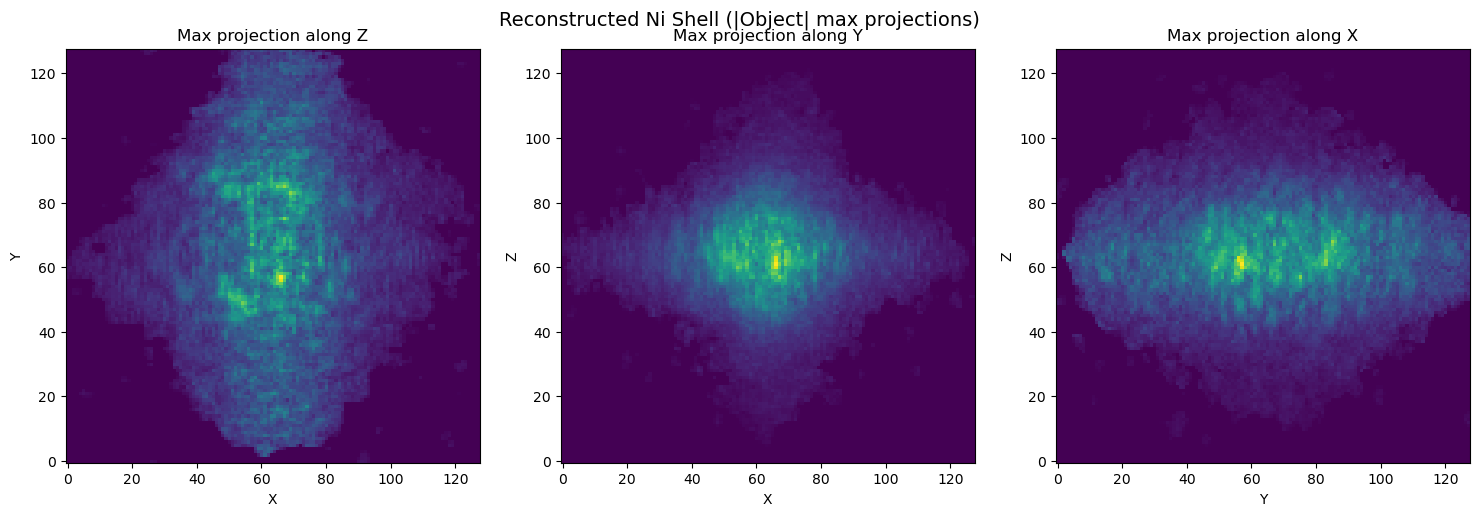

FileNotFoundError: [Errno 2] No such file or directory: '/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6_v2/results/reconstructed_obj_A_magnitude.npy'

In [10]:
# =============================================================================
# PHASE RETRIEVAL FOR I_A (Ni SHELL) - SHRINKWRAP SUPPORT
# =============================================================================
# Reconstructs the Ni (anomalous) electron density from I_A = |F_A|²
# Uses shrinkwrap algorithm for dynamic support estimation
# =============================================================================

import numpy as np
from scipy.fft import fftn, ifftn, fftshift, ifftshift
from scipy.ndimage import gaussian_filter, binary_dilation, generate_binary_structure
import matplotlib.pyplot as plt

# # =============================================================================
# # LOAD DATA
# # =============================================================================

# base_path = "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6_v2/results/"

# F_A = np.load(base_path + "F_A_3d.npy")
# I_A = F_A**2  # Intensity = |F|²

# print(f"I_A shape: {I_A.shape}")
# print(f"I_A range: [{I_A.min():.2e}, {I_A.max():.2e}]")

# # Amplitude in reciprocal space (what we measure)
amp_measured = np.sqrt(I_A)

# =============================================================================
# PHASE RETRIEVAL PARAMETERS
# =============================================================================

N_ITERATIONS = 500          # Total iterations
HIO_BETA = 0.9              # HIO feedback parameter
ER_EVERY = 50               # Run ER every N iterations (helps convergence)

# Shrinkwrap parameters
SHRINKWRAP_EVERY = 20       # Update support every N iterations
SHRINKWRAP_SIGMA_START = 3.0  # Initial Gaussian blur sigma
SHRINKWRAP_SIGMA_END = 1.0    # Final Gaussian blur sigma
SHRINKWRAP_THRESHOLD = 0.1    # Threshold as fraction of max

# Random seed for reproducibility
np.random.seed(42)

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def apply_fourier_constraint(obj, amp_measured):
    """
    Apply Fourier magnitude constraint.
    Keep measured amplitude, replace phase with current estimate.
    """
    obj_ft = fftshift(fftn(ifftshift(obj)))
    phase = np.angle(obj_ft)
    obj_ft_constrained = amp_measured * np.exp(1j * phase)
    return fftshift(ifftn(ifftshift(obj_ft_constrained)))


def update_support_shrinkwrap(obj, sigma, threshold):
    """
    Update support using shrinkwrap algorithm.
    1. Blur the object magnitude
    2. Threshold to get new support
    """
    obj_mag = np.abs(obj)
    obj_blurred = gaussian_filter(obj_mag, sigma=sigma)
    threshold_value = threshold * obj_blurred.max()
    support = obj_blurred > threshold_value
    
    # Optional: dilate slightly to avoid cutting edges
    # struct = generate_binary_structure(3, 1)
    # support = binary_dilation(support, structure=struct, iterations=1)
    
    return support


def error_reduction(obj, support):
    """ER: Set object to zero outside support."""
    obj_new = obj.copy()
    obj_new[~support] = 0
    return obj_new


def hybrid_input_output(obj, obj_prev, support, beta=0.9):
    """
    HIO: Hybrid Input-Output algorithm.
    Inside support: keep current estimate
    Outside support: apply feedback
    """
    obj_new = obj.copy()
    outside = ~support
    obj_new[outside] = obj_prev[outside] - beta * obj[outside]
    return obj_new


def compute_error(obj, amp_measured):
    """Compute R-factor (error metric)."""
    obj_ft = fftshift(fftn(ifftshift(obj)))
    amp_calc = np.abs(obj_ft)
    
    # R-factor
    r_factor = np.sum(np.abs(amp_calc - amp_measured)) / np.sum(amp_measured)
    return r_factor


def initialize_object(amp_measured, method='random_phase'):
    """Initialize object with random phases."""
    if method == 'random_phase':
        # Random phases in Fourier space
        random_phase = np.exp(2j * np.pi * np.random.random(amp_measured.shape))
        obj_ft = amp_measured * random_phase
        obj = fftshift(ifftn(ifftshift(obj_ft)))
    elif method == 'autocorrelation':
        # Start from autocorrelation (Patterson function)
        obj_ft = amp_measured  # No phase
        obj = fftshift(ifftn(ifftshift(obj_ft)))
    return obj


def initialize_support(shape, method='sphere', radius_fraction=0.3):
    """Initialize support estimate."""
    center = np.array(shape) // 2
    
    if method == 'sphere':
        # Spherical support
        z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
        r = np.sqrt((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2)
        radius = min(shape) * radius_fraction
        support = r < radius
    elif method == 'cube':
        # Cubic support
        half_size = int(min(shape) * radius_fraction)
        support = np.zeros(shape, dtype=bool)
        slices = tuple(slice(c - half_size, c + half_size) for c in center)
        support[slices] = True
    elif method == 'full':
        # Start with everything (shrinkwrap will tighten)
        support = np.ones(shape, dtype=bool)
    
    return support


# =============================================================================
# PHASE RETRIEVAL MAIN LOOP
# =============================================================================

print("\n" + "=" * 60)
print("PHASE RETRIEVAL - HIO + SHRINKWRAP")
print("=" * 60)
print(f"Iterations: {N_ITERATIONS}")
print(f"HIO beta: {HIO_BETA}")
print(f"Shrinkwrap every: {SHRINKWRAP_EVERY} iterations")
print(f"Shrinkwrap sigma: {SHRINKWRAP_SIGMA_START} → {SHRINKWRAP_SIGMA_END}")
print(f"Shrinkwrap threshold: {SHRINKWRAP_THRESHOLD}")
print()

# Initialize
obj = initialize_object(amp_measured, method='random_phase')
support = initialize_support(amp_measured.shape, method='sphere', radius_fraction=0.4)
obj_prev = obj.copy()

# Track progress
errors = []
support_sizes = []

print("Starting iterations...")
for i in range(N_ITERATIONS):
    # Store previous object for HIO
    obj_prev = obj.copy()
    
    # Fourier constraint: replace amplitude with measured
    obj = apply_fourier_constraint(obj, amp_measured)
    
    # Real-space constraint: ER or HIO
    if (i + 1) % ER_EVERY == 0:
        # Error Reduction
        obj = error_reduction(obj, support)
    else:
        # Hybrid Input-Output
        obj = hybrid_input_output(obj, obj_prev, support, beta=HIO_BETA)
    
    # Shrinkwrap: update support
    if (i + 1) % SHRINKWRAP_EVERY == 0:
        # Linearly decrease sigma over iterations
        progress = i / N_ITERATIONS
        sigma = SHRINKWRAP_SIGMA_START + progress * (SHRINKWRAP_SIGMA_END - SHRINKWRAP_SIGMA_START)
        support = update_support_shrinkwrap(obj, sigma, SHRINKWRAP_THRESHOLD)
        support_sizes.append(support.sum())
    
    # Compute error
    if (i + 1) % 10 == 0:
        error = compute_error(obj, amp_measured)
        errors.append(error)
        
        if (i + 1) % 50 == 0:
            support_frac = support.sum() / support.size * 100
            print(f"  Iter {i+1:4d}: R = {error:.4f}, Support = {support_frac:.1f}%")

print("\n✓ Phase retrieval complete!")

# Final object (take real part or magnitude depending on your preference)
obj_final = obj.copy()
obj_mag = np.abs(obj_final)
obj_real = np.real(obj_final)

print(f"\nFinal R-factor: {errors[-1]:.4f}")
print(f"Final support fraction: {support.sum() / support.size * 100:.1f}%")

# =============================================================================
# VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

z_center = obj_mag.shape[0] // 2

# Row 1: Reconstructed object magnitude
im0 = axes[0, 0].imshow(obj_mag[z_center], cmap='viridis', origin='lower')
axes[0, 0].set_title(f'|Object| - XY (z={z_center})')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(obj_mag[:, obj_mag.shape[1]//2, :], cmap='viridis', origin='lower', aspect='auto')
axes[0, 1].set_title('|Object| - XZ')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(obj_mag[:, :, obj_mag.shape[2]//2], cmap='viridis', origin='lower', aspect='auto')
axes[0, 2].set_title('|Object| - YZ')
plt.colorbar(im2, ax=axes[0, 2])

# Support
im3 = axes[0, 3].imshow(support[z_center], cmap='gray', origin='lower')
axes[0, 3].set_title('Final Support - XY')
plt.colorbar(im3, ax=axes[0, 3])

# Row 2: Phase and convergence
phase = np.angle(obj_final)
im4 = axes[1, 0].imshow(phase[z_center], cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title('Phase - XY')
plt.colorbar(im4, ax=axes[1, 0], label='rad')

im5 = axes[1, 1].imshow(phase[:, phase.shape[1]//2, :], cmap='twilight', origin='lower', aspect='auto', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title('Phase - XZ')
plt.colorbar(im5, ax=axes[1, 1])

# Convergence plot
axes[1, 2].semilogy(np.arange(10, N_ITERATIONS+1, 10), errors)
axes[1, 2].set_xlabel('Iteration')
axes[1, 2].set_ylabel('R-factor')
axes[1, 2].set_title('Convergence')
axes[1, 2].grid(True, alpha=0.3)

# Support size evolution
axes[1, 3].plot(np.arange(SHRINKWRAP_EVERY, N_ITERATIONS+1, SHRINKWRAP_EVERY), support_sizes)
axes[1, 3].set_xlabel('Iteration')
axes[1, 3].set_ylabel('Support voxels')
axes[1, 3].set_title('Support Evolution')
axes[1, 3].grid(True, alpha=0.3)

plt.suptitle('Phase Retrieval Results - I_A (Ni Shell)', fontsize=14)
plt.tight_layout()
plt.show()

# =============================================================================
# 3D PROJECTIONS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Max projections
axes[0].imshow(obj_mag.max(axis=0), cmap='viridis', origin='lower')
axes[0].set_title('Max projection along Z')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

axes[1].imshow(obj_mag.max(axis=1), cmap='viridis', origin='lower')
axes[1].set_title('Max projection along Y')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

axes[2].imshow(obj_mag.max(axis=2), cmap='viridis', origin='lower')
axes[2].set_title('Max projection along X')
axes[2].set_xlabel('Y')
axes[2].set_ylabel('Z')

plt.suptitle('Reconstructed Ni Shell (|Object| max projections)', fontsize=14)
plt.tight_layout()
plt.show()

# =============================================================================
# SAVE RESULTS
# =============================================================================

output_dir = base_path  # Same directory as input
np.save(output_dir + "reconstructed_obj_A_magnitude.npy", obj_mag.astype(np.float32))
np.save(output_dir + "reconstructed_obj_A_phase.npy", phase.astype(np.float32))
np.save(output_dir + "reconstructed_obj_A_complex.npy", obj_final.astype(np.complex64))
np.save(output_dir + "final_support_A.npy", support)

print(f"\n✓ Results saved to {output_dir}")
print("  - reconstructed_obj_A_magnitude.npy")
print("  - reconstructed_obj_A_phase.npy")
print("  - reconstructed_obj_A_complex.npy")
print("  - final_support_A.npy")

In [ ]:
# =============================================================================
# FA RECONSTRUCTION WITH SHRINKWRAP SUPPORT (NO INJECTED SUPPORT)
# =============================================================================

# --- Initialize CDI with AutoCorrelationSupport (dynamic support) ---
cdi_FA = CDI(
    fftshift(I_A),
    obj=None, 
    support=None,  # No injected support - will be estimated
)

# --- Standard initialization steps ---
cdi_FA = AutoCorrelationSupport(threshold=0.1) * cdi_FA  # Initial support from autocorrelation
cdi_FA = InitFreePixels() * cdi_FA
cdi_FA = ScaleObj() * cdi_FA
cdi_FA = ShowCDI() * ScaleObj() * InitObjRandom(src="support", amin=0.8, amax=1, phirange=0.5) * cdi_FA

# --- Phase retrieval with shrinkwrap support update ---
support_update = 200  # Support update period during reconstruction
threshold_relative = 0.25  # Support threshold (fraction of max object magnitude)

sup = SupportUpdate(
    threshold_relative=threshold_relative,
    smooth_width=(2, 1, 600),  # Gaussian blur: decays from 2 to 1 over 600 cycles
    post_expand=(1, -2, 1)    # Expand then shrink support edges
)

show_cdi = 100
plt.figure()

# Reconstruction with support updates
cdi_FA = (sup * HIO(beta=0.5, calc_llk=50, show_cdi=show_cdi, positivity=True)**support_update)**(1600//support_update) * cdi_FA
cdi_FA = (sup * RAAR(beta=0.5, calc_llk=50, show_cdi=show_cdi, positivity=True)**support_update)**(800//support_update) * cdi_FA

print("FA reconstruction complete")


In [ ]:
# =============================================================================
# VISUALIZE FA RECONSTRUCTION
# =============================================================================

import matplotlib.pyplot as plt
from numpy.fft import fftshift

# -----------------------------------------------------------------------------
# 1. Extract object and support from CDI
# -----------------------------------------------------------------------------
obj_FA = fftshift(cdi_FA.get_obj())
support_FA = fftshift(cdi_FA.get_support())

print(f"Object shape: {obj_FA.shape}")
print(f"Object amplitude range: [{np.abs(obj_FA).min():.2f}, {np.abs(obj_FA).max():.2f}]")

# -----------------------------------------------------------------------------
# 2. Plot central slices - Amplitude
# -----------------------------------------------------------------------------
amplitude = np.abs(obj_FA)
nz, ny, nx = amplitude.shape

fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Top row: Amplitude
axes[0, 0].imshow(amplitude[nz//2, :, :], cmap='viridis')
axes[0, 0].set_title(f'Amplitude - XY (z={nz//2})')

axes[0, 1].imshow(amplitude[:, ny//2, :], cmap='viridis')
axes[0, 1].set_title(f'Amplitude - XZ (y={ny//2})')

axes[0, 2].imshow(amplitude[:, :, nx//2], cmap='viridis')
axes[0, 2].set_title(f'Amplitude - YZ (x={nx//2})')

# Bottom row: Phase (masked by support)
phase = np.angle(obj_FA)
phase_masked = np.where(support_FA > 0, phase, np.nan)  # Only show phase inside support

axes[1, 0].imshow(phase_masked[nz//2, :, :], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title(f'Phase - XY (z={nz//2})')

axes[1, 1].imshow(phase_masked[:, ny//2, :], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title(f'Phase - XZ (y={ny//2})')

axes[1, 2].imshow(phase_masked[:, :, nx//2], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1, 2].set_title(f'Phase - YZ (x={nx//2})')

for ax in axes.flat:
    ax.axis('off')

plt.suptitle('FA Reconstruction', fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Support overlay check - does object fill the support?
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (ax, sl, title) in enumerate(zip(
    axes,
    [amplitude[nz//2, :, :], amplitude[:, ny//2, :], amplitude[:, :, nx//2]],
    ['XY', 'XZ', 'YZ']
)):
    ax.imshow(sl, cmap='viridis')
    # Overlay support contour
    support_slice = [support_FA[nz//2, :, :], support_FA[:, ny//2, :], support_FA[:, :, nx//2]][i]
    ax.contour(support_slice, levels=[0.5], colors='red', linewidths=1)
    ax.set_title(f'{title} - Amplitude + Support boundary')
    ax.axis('off')

plt.suptitle('FA: Object amplitude with support contour (red)', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
# cdi = CDI(fftshift(data_new), obj=None, support=None)
# cdi = InitFreePixels() * cdi

cdi_FA = CDI(fftshift(data_new_FA), obj=None, support=None)
cdi_FA = InitFreePixels() * cdi_FA

cdi_FN = CDI(fftshift(data_new_FN), obj=None, support=None)
cdi_FN = InitFreePixels() * cdi_FN

cdi_FT = CDI(fftshift(data_new_FT), obj=None, support=None)
cdi_FT = InitFreePixels() * cdi_FT

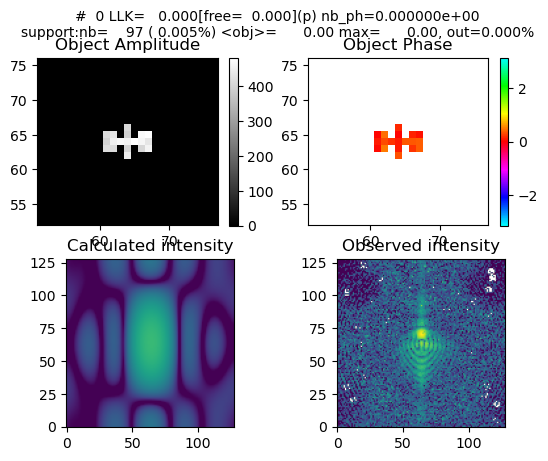

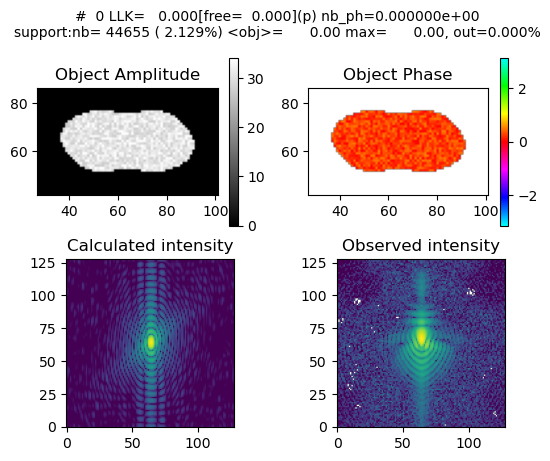

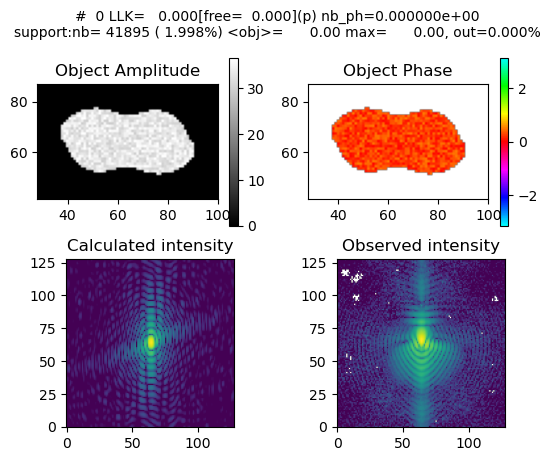

In [19]:
"""WAS NOT COMMENTED"""
# cdi = AutoCorrelationSupport(threshold=0.1) * cdi
# cdi = ShowCDI() * ScaleObj() * InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi

# cdi_FA = AutoCorrelationSupport(threshold=0.1) * cdi_FA
# cdi_FA = ShowCDI() * ScaleObj() * InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi_FA

cdi_FA = AutoCorrelationSupport(threshold=0.1) * cdi_FA
cdi_FA = ShowCDI() * ScaleObj() * InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi_FA

cdi_FN = AutoCorrelationSupport(threshold=0.1) * cdi_FN
cdi_FN = ShowCDI() * ScaleObj() * InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi_FN

cdi_FT = AutoCorrelationSupport(threshold=0.1) * cdi_FT
cdi_FT = ShowCDI() * ScaleObj() * InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi_FT

In [15]:
"""WAS NOT COMMENTED"""
# # THis initial reconstruction process usually sucks, what if I can improve it?

# plt.figure()

# # Re-init randomly the object, in case we want to do this several times
# # cdi = InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi

# # Next three lines 
# # sup = SupportUpdate(threshold_relative=0.4) #, method='rms') #, smooth_width=(2,0.5,600))
# # cdi = (sup * RAAR(beta=0.9, calc_llk=50, show_cdi=200, fig_num=-1)**20)**100 * cdi
# # cdi = (sup * ER(calc_llk=50, show_cdi=200, fig_num=-1)**20)**100 * cdi

# # Charlie advice
# # --- STRONGER, SAFER SHRINK-WRAP ---
# sup = SupportUpdate(
#     method='rms',                 # robust thresholding
#     threshold_relative=0.30,      # stricter than 0.15; prevents creep
#     smooth_width=(3,3,3),         # more blur => fewer peppery islands
#     max_fraction=0.20,            # hard stop long before flooding
#     # keep_largest=True,          # <-- enable if available in your PyNX (keeps only the largest blob)
# )

# # --- STABLE SCHEDULING ---
# # 1) Let RAAR settle ~no shrink-wrap for a while:
# cdi = RAAR(beta=0.80, calc_llk=100, show_cdi=200, fig_num=-1)**300 * cdi

# # 2) Do a *single* shrink-wrap pass:
# cdi = sup * cdi

# # 3) Another RAAR block, then *optionally* one more shrink-wrap:
# cdi = RAAR(beta=0.80, calc_llk=100, show_cdi=200, fig_num=-1)**300 * cdi
# cdi = sup * cdi   # (optional; skip if support already looks tight)

# # 4) Freeze support and polish with ER only:
# cdi = ER(calc_llk=100, show_cdi=200, fig_num=-1)**800 * cdi


'WAS NOT COMMENTED'

In [16]:
"""WAS NOT COMMENTED"""
# obj = fftshift(cdi.get_obj())
# support = fftshift(cdi.get_support())
# obj, support = center_object(obj, support=support)

'WAS NOT COMMENTED'

In [17]:
"""WAS NOT COMMENTED"""
# #plot_2D_slices_middle_and_histogram(obj)
# px,py,pz = np.shape(obj)
# plt.figure()
# plt.imshow(abs(obj).sum(axis=1))

'WAS NOT COMMENTED'

In [20]:
"""WAS NOT COMMENTED"""
# mask = np.zeros(np.shape(data_new))
# # Create the pynx CDI object with the starting object and the 3D mask
# # careful not to forget the fftshift. python consider the origin of the array to be 
# # the pixel on the upper left corner, not at the center of the array.
# # cdi = CDI(fftshift(data), obj=obj_init, mask=fftshift(mask))
# cdi = CDI(fftshift(data_new), obj=None, support=None, mask=fftshift(mask))
# cdi = ScaleObj() * cdi # Rescale the object intensity according to the diffraction data, will help starting the reconstruction
# cdi = InitPSF(fwhm=.5, eta=0.05)*cdi # Used to take partial coherence of the x-ray beam into account
# update_psf = 20 # PSF update period used during the reconstruction 
# cdi = AutoCorrelationSupport(threshold=0.1) * cdi # Make a support guess from the autocorrelation

mask_FA = np.zeros(np.shape(data_new_FA))
# Create the pynx CDI object with the starting object and the 3D mask
# careful not to forget the fftshift. python consider the origin of the array to be 
# the pixel on the upper left corner, not at the center of the array.
# cdi = CDI(fftshift(data), obj=obj_init, mask=fftshift(mask))
cdi_FA = CDI(fftshift(data_new_FA), obj=None, support=None, mask=fftshift(mask_FA))
cdi_FA = ScaleObj() * cdi_FA # Rescale the object intensity according to the diffraction data, will help starting the reconstruction
cdi_FA = InitPSF(fwhm=.5, eta=0.05)*cdi_FA # Used to take partial coherence of the x-ray beam into account
update_psf = 20 # PSF update period used during the reconstruction 
cdi_FA = AutoCorrelationSupport(threshold=0.1) * cdi_FA # Make a support guess from the autocorrelation

mask_FN = np.zeros(np.shape(data_new_FN))
cdi_FN = CDI(fftshift(data_new_FN), obj=None, support=None, mask=fftshift(mask_FN))
cdi_FN = ScaleObj() * cdi_FN # Rescale the object intensity according to the diffraction data, will help starting the reconstruction
cdi_FN = InitPSF(fwhm=.5, eta=0.05)*cdi_FN # Used to take partial coherence of the x-ray beam into account
update_psf = 20 # PSF update period used during the reconstruction 
cdi_FN = AutoCorrelationSupport(threshold=0.1) * cdi_FN # Make a support guess from the autocorrelation

mask_FT = np.zeros(np.shape(data_new_FT))
cdi_FT = CDI(fftshift(data_new_FT), obj=None, support=None, mask=fftshift(mask_FT))
cdi_FT = ScaleObj() * cdi_FT # Rescale the object intensity according to the diffraction data, will help starting the reconstruction
cdi_FT = InitPSF(fwhm=.5, eta=0.05)*cdi_FT # Used to take partial coherence of the x-ray beam into account
update_psf = 20 # PSF update period used during the reconstruction 
cdi_FT = AutoCorrelationSupport(threshold=0.1) * cdi_FT # Make a support guess from the autocorrelation

In [21]:
"""WAS NOT COMMENTED"""
# # cdi is an object that contains all informations on the reconstruction for example here's the initial support to be used
# # at the start of the reconstruction
# plot_3D_projections(fftshift(cdi.get_support()), fig_title='initial support', log_scale=False)

# # you can access everything contained in cdi with its dictionary cdi.__dict__

'WAS NOT COMMENTED'

In [22]:
#!pynx-cdi-id01 --data alignment_S2280.cxi --mask maxipix --saveplot --maxsize 256

In [23]:
"""WAS NOT COMMENTED"""
# # We create a support update method to change the support from time to time during the reconstruction

# support_update = 20 # support update period during the reconstruction
# threshold_relative = .25 # support threshold (will cut everything where the object module is 
# # below the threshold * maximum value of the object module)

# sup = SupportUpdate(threshold_relative=threshold_relative,
#                     smooth_width=(2,1,600),
#                     post_expand=(1,-2,1))

'WAS NOT COMMENTED'

In [24]:
# (Sup*ER**50)**4 * (Sup*RAAR**50)**4 * Sup*RAAR**40 * RAAR**10 * (Sup*RAAR**50)**4 * DetwinRAAR**10*Sup*RAAR**50 * (Sup*RAAR**50)**2

In [25]:
# show_cdi = 100 # Show the reconstruction every show_cdi iterations 
# # (you don't want to see at each iteration, it will make too many figures)

# plt.figure()
# # Reconstruction algortihm (not fixed, this can be changed to any other algorithm you want)
# cdi = (sup * HIO(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(400//support_update)* cdi 
# #cdi = (sup * DetwinRAAR(beta=0.9)**support_update)**(800//support_update)* cdi
# cdi = (sup * RAAR(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(800//support_update)* cdi
# cdi = (sup * ER(calc_llk=20, show_cdi=show_cdi, update_psf=update_psf) ** support_update)**(500//support_update) *cdi

### FA final reconstruction

In [ ]:
# We create a support update method to change the support from time to time during the reconstruction

support_update = 100 # support update period during the reconstruction
# threshold_relative = .25
threshold_relative = 0.3 # support threshold (will cut everything where the object module is 
# below the threshold * maximum value of the object module)

sup = SupportUpdate(threshold_relative=threshold_relative,
                    smooth_width=(2,1,600), # was smooth_width=(2,1,600), "3-value tuple (a, b, nb) → time-varying blur: it decays exponentially from a to b over nb cycles (using cdi.cycle)."
                    post_expand=(1,-2,1)) # was post_expand=(1,-2,1) ? "‘post_expand=(-2,3)’ will shrink and then expand the support by respectively 2 and 3 pixels"
update_psf = 20 # PSF update period used during the reconstruction 
print(f"update_psf = {update_psf}") # just so you can see it
# anchor for ctrl-f
show_cdi = 100 # Show the reconstruction every show_cdi iterations 
# (you don't want to see at each iteration, it will make too many figures)



plt.figure()
# Reconstruction algortihm (not fixed, this can be changed to any other algorithm you want)
cdi_FA = (sup * HIO(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(1600//support_update)* cdi_FA # 3200 # 400 # 600
# cdi = (sup * DetwinRAAR(detwin_axis = 0, beta=0.9)**support_update)**(400//support_update)* cdi
cdi_FA = (sup * RAAR(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(800//support_update)* cdi_FA #1600 # 800
# cdi = (sup * ER(calc_llk=20, show_cdi=show_cdi, update_psf=update_psf) ** support_update)**(500//support_update) *cdi

In [28]:
"""This is the saving that correctly centers (for ex) FA amp and FA support"""
obj = fftshift(cdi_FA.get_obj())
support = fftshift(cdi_FA.get_support())
print(f"Shape obj: {np.shape(obj)}, type cdi_result: {type(obj)}")
print(f"Shape support: {np.shape(support)}, type obj: {type(support)}")
obj, support = center_object(obj, support=support)

savedir = '/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results'
spec_name = 'from_single_notebook_and_orientation'
result_dir = Path(savedir) / spec_name / Path(filename).stem 
result_dir.mkdir(parents=True, exist_ok=True)

# save inside folder named after the stitched file
support_path = result_dir / f"support_FA_noise_{noise_label}.npy"
np.save(result_dir / f"support_FA_noise_{noise_label}.npy", support)
print(f"✅ Saved support to: {support_path}")

obj_path = result_dir / f"obj_FA.npy_noise_{noise_label}"
np.save(result_dir / f"obj_FA.npy_noise_{noise_label}", obj)
print(f"✅ Saved obj to: {obj_path}")

Shape obj: (128, 128, 128), type cdi_result: <class 'numpy.ndarray'>
Shape support: (128, 128, 128), type obj: <class 'numpy.ndarray'>
✅ Saved support to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/support_FA.npy
✅ Saved obj to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/obj_FA.npy


### FN final reconstruction

In [ ]:
# We create a support update method to change the support from time to time during the reconstruction

support_update = 100 # support update period during the reconstruction
# threshold_relative = .25
threshold_relative = 0.4 # support threshold (will cut everything where the object module is # was 0.4
# below the threshold * maximum value of the object module)

sup = SupportUpdate(threshold_relative=threshold_relative,
                    smooth_width=(2,1,500), # was smooth_width=(2,1,600), "3-value tuple (a, b, nb) → time-varying blur: it decays exponentially from a to b over nb cycles (using cdi.cycle)."
                    post_expand=(1,-2,1)) # was post_expand=(1,-2,1) ? "‘post_expand=(-2,3)’ will shrink and then expand the support by respectively 2 and 3 pixels"
update_psf = 20 # PSF update period used during the reconstruction 
print(f"update_psf = {update_psf}") # just so you can see it
# anchor for ctrl-f
show_cdi = 100 # Show the reconstruction every show_cdi iterations 
# (you don't want to see at each iteration, it will make too many figures)



plt.figure()
# Reconstruction algortihm (not fixed, this can be changed to any other algorithm you want)
cdi_FN = (sup * HIO(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(1600//support_update)* cdi_FN # 0.9 and 3200, 0.9 and 1000, and 400
# cdi = (sup * DetwinRAAR(detwin_axis = 0, beta=0.9)**support_update)**(400//support_update)* cdi
cdi_FN = (sup * RAAR(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(800//support_update)* cdi_FN # 0.35 and 1600, 0.9 and 2000, and 800
# cdi = (sup * ER(calc_llk=20, show_cdi=show_cdi, update_psf=update_psf) ** support_update)**(500//support_update) *cdi

In [29]:
"""This is the saving that correctly centers (for ex) FN amp and FN support"""
obj = fftshift(cdi_FN.get_obj())
support = fftshift(cdi_FN.get_support())
print(f"Shape obj: {np.shape(obj)}, type cdi_result: {type(obj)}")
print(f"Shape support: {np.shape(support)}, type obj: {type(support)}")
obj, support = center_object(obj, support=support)

savedir = '/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results'
spec_name = 'from_single_notebook_and_orientation'
result_dir = Path(savedir) / spec_name / Path(filename).stem 
result_dir.mkdir(parents=True, exist_ok=True)

# save inside folder named after the stitched file
support_path = result_dir / f"support_FN_noise_{noise_label}.npy"
np.save(result_dir / f"support_FN.npy", support)
print(f"✅ Saved support to: {support_path}")

obj_path = result_dir / f"obj_FN_noise_{noise_label}.npy"
np.save(result_dir / f"obj_FN_noise_{noise_label}.npy", obj)
print(f"✅ Saved obj to: {obj_path}")

Shape obj: (128, 128, 128), type cdi_result: <class 'numpy.ndarray'>
Shape support: (128, 128, 128), type obj: <class 'numpy.ndarray'>
✅ Saved support to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/support_FN.npy
✅ Saved obj to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/obj_FN.npy


### FT final reconstruction

In [ ]:
# We create a support update method to change the support from time to time during the reconstruction

support_update = 100 # support update period during the reconstruction
# threshold_relative = .25
threshold_relative = 0.275 # support threshold (will cut everything where the object module is 
# below the threshold * maximum value of the object module)

sup = SupportUpdate(threshold_relative=threshold_relative,
                    smooth_width=(2,1,600), # was smooth_width=(2,1,600), "3-value tuple (a, b, nb) → time-varying blur: it decays exponentially from a to b over nb cycles (using cdi.cycle)."
                    post_expand=(1,-2,1)) # was post_expand=(1,-2,1) ? "‘post_expand=(-2,3)’ will shrink and then expand the support by respectively 2 and 3 pixels"
update_psf = 20 # PSF update period used during the reconstruction 
print(f"update_psf = {update_psf}") # just so you can see it
# anchor for ctrl-f
show_cdi = 100 # Show the reconstruction every show_cdi iterations 
# (you don't want to see at each iteration, it will make too many figures)



plt.figure()
# Reconstruction algortihm (not fixed, this can be changed to any other algorithm you want)
cdi_FT = (sup * HIO(beta=0.95, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(1600//support_update)* cdi_FT # 0.9 and 3200
# cdi = (sup * DetwinRAAR(detwin_axis = 0, beta=0.9)**support_update)**(800//support_update)* cdi
cdi_FT = (sup * RAAR(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(800//support_update)* cdi_FT # 0.05 and 1600
# cdi = (sup * ER(calc_llk=20, show_cdi=show_cdi, update_psf=update_psf) ** support_update)**(500//support_update) *cdi

In [30]:
"""This is the saving that correctly centers (for ex) FT amp and FT support"""
obj = fftshift(cdi_FT.get_obj())
support = fftshift(cdi_FT.get_support())
print(f"Shape obj: {np.shape(obj)}, type cdi_result: {type(obj)}")
print(f"Shape support: {np.shape(support)}, type obj: {type(support)}")
obj, support = center_object(obj, support=support)

savedir = '/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results'
spec_name = 'from_single_notebook_and_orientation'
result_dir = Path(savedir) / spec_name / Path(filename).stem 
result_dir.mkdir(parents=True, exist_ok=True)

# save inside folder named after the stitched file
support_path = result_dir / f"support_FT_noise_{noise_label}.npy"
np.save(result_dir / f"support_FT_noise_{noise_label}.npy", support)
print(f"✅ Saved support to: {support_path}")

obj_path = result_dir / f"obj_FT_noise_{noise_label}.npy"
np.save(result_dir / f"obj_FT_noise_{noise_label}.npy", obj)
print(f"✅ Saved obj to: {obj_path}")

Shape obj: (128, 128, 128), type cdi_result: <class 'numpy.ndarray'>
Shape support: (128, 128, 128), type obj: <class 'numpy.ndarray'>
✅ Saved support to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/support_FT.npy
✅ Saved obj to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/from_single_notebook_and_orientation/FTFAFNDPHI_sim_big_particle_noise_none/obj_FT.npy


In [75]:
"""WAS NOT COMMENTED"""
# # We create a support update method to change the support from time to time during the reconstruction

# support_update = 100 # support update period during the reconstruction
# # threshold_relative = .25
# threshold_relative = 0.3 # support threshold (will cut everything where the object module is 
# # below the threshold * maximum value of the object module)

# sup = SupportUpdate(threshold_relative=threshold_relative,
#                     smooth_width=(2,1,600), # was smooth_width=(2,1,600), "3-value tuple (a, b, nb) → time-varying blur: it decays exponentially from a to b over nb cycles (using cdi.cycle)."
#                     post_expand=(1,-2,1)) # was post_expand=(1,-2,1) ? "‘post_expand=(-2,3)’ will shrink and then expand the support by respectively 2 and 3 pixels"

# print(f"update_psf = {update_psf}") # just so you can see it
# # anchor for ctrl-f
# show_cdi = 100 # Show the reconstruction every show_cdi iterations 
# # (you don't want to see at each iteration, it will make too many figures)



# plt.figure()
# # Reconstruction algortihm (not fixed, this can be changed to any other algorithm you want)
# cdi = (sup * HIO(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(1600//support_update)* cdi # 3200 # 400 # 600
# # cdi = (sup * DetwinRAAR(detwin_axis = 0, beta=0.9)**support_update)**(400//support_update)* cdi
# cdi = (sup * RAAR(beta=0.9, calc_llk=100, show_cdi=show_cdi, update_psf=update_psf)**support_update)**(800//support_update)* cdi #1600 # 800
# # cdi = (sup * ER(calc_llk=20, show_cdi=show_cdi, update_psf=update_psf) ** support_update)**(500//support_update) *cdi

'WAS NOT COMMENTED'

In [27]:
"""This is the saving that correctly centers (for ex) FA amp and FA support"""
# obj = fftshift(cdi.get_obj())
# support = fftshift(cdi.get_support())
# print(f"Shape obj: {np.shape(obj)}, type cdi_result: {type(obj)}")
# print(f"Shape support: {np.shape(support)}, type obj: {type(support)}")
# obj, support = center_object(obj, support=support)

# savedir = '/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results'
# result_dir = Path(savedir) / Path(filename).stem
# result_dir.mkdir(parents=True, exist_ok=True)

# # save inside folder named after the stitched file
# support_path = result_dir / "support_FA.npy"
# np.save(result_dir / "support_FA.npy", support)
# print(f"✅ Saved support to: {support_path}")

# obj_path = result_dir / "obj_FA.npy"
# np.save(result_dir / "obj_FA.npy", obj)
# print(f"✅ Saved obj to: {obj_path}")

Shape obj: (128, 128, 128), type cdi_result: <class 'numpy.ndarray'>
Shape support: (128, 128, 128), type obj: <class 'numpy.ndarray'>
✅ Saved support to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/FTFAFNDPHI_sim_big_particle_noise_none/support_FA.npy
✅ Saved obj to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/FTFAFNDPHI_sim_big_particle_noise_none/obj_FA.npy


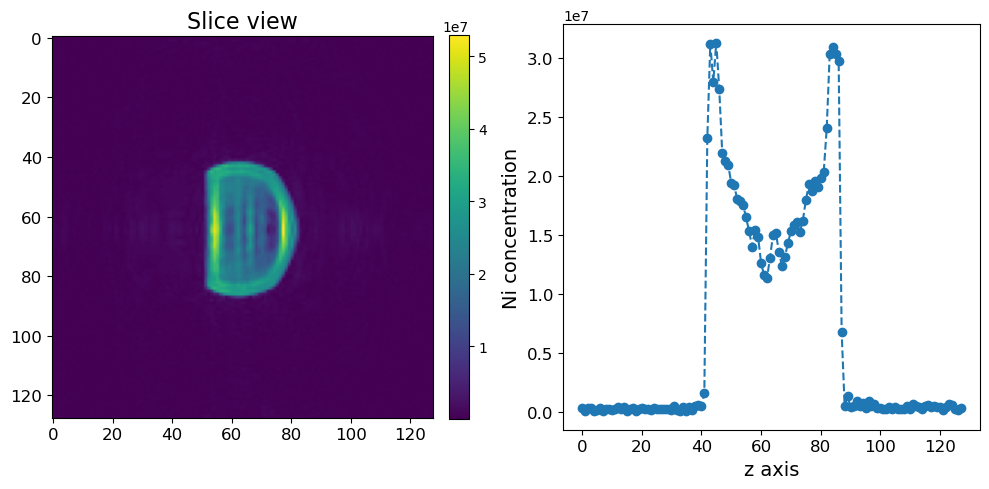

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
px, py, pz = obj.shape
im = ax1.imshow(np.abs(obj[px//2, :, :]))
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Slice view", fontsize=16)
ax1.tick_params(labelsize=12)

# Right subplot: line plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.abs(obj[px//2, :, pz//2]), "--o")
ax2.set_ylabel('Ni concentration', fontsize=14)
ax2.set_xlabel('z axis', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


In [37]:
FA_amp = obj
def apply_support(volume, support, *, thresh=0.5, outside="zero"):
    """
    Apply a 3D support to a 3D complex (or real) volume.

    Parameters
    ----------
    volume : np.ndarray
        3D array (can be complex).
    support : np.ndarray
        3D array, same shape as `volume`. Can be bool or float in [0,1].
    thresh : float
        If `support` is not boolean, values > thresh are considered inside support.
    outside : {"zero","nan"}
        What to put outside the support: 0 or NaN.

    Returns
    -------
    masked : np.ndarray
        `volume` with values outside the support removed.
    mask : np.ndarray (bool)
        The boolean mask actually used.
    """
    if volume.shape != support.shape:
        raise ValueError(f"Shape mismatch: volume {volume.shape} vs support {support.shape}")

    mask = support > thresh if support.dtype != bool else support
    if outside == "zero":
        masked = volume * mask  # fast for complex arrays
    elif outside == "nan":
        masked = np.where(mask, volume, np.nan + 0j if np.iscomplexobj(volume) else np.nan)
    else:
        raise ValueError("outside must be 'zero' or 'nan'")

    return masked, mask

# --- Example: load supports and apply them ---
# (adjust paths/names to yours)
FA_support = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/FTFAFNDPHI_sim_big_particle_noise_none/support_FA.npy")
# FN_support = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/FTFAFNDPHI_sim_big_particle_noise_none/support_FN.npy")
# FT_support = np.load("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/results/FTFAFNDPHI_sim_big_particle_noise_none/support_FT.npy")

# FA_support = np.rot90(FA_support, 2, (1,2))

# FA_support = np.rot90(FA_support, 1, (1,2))
# FN_support = np.rot90(FN_support, 1, (1,2))
# FT_support = np.rot90(FT_support, 1, (1,2))

FA_amp_masked, mask_FA = apply_support(FA_amp, FA_support, thresh=0.5, outside="nan")
# FN_amp_masked, mask_FN = apply_support(FN_amp, FN_support, thresh=0.01, outside="nan")
# FT_amp_masked, mask_FT = apply_support(FT_amp, FT_support, thresh=0.01, outside="nan")


# Optional: quick sanity print
for name, m in [("FA", mask_FA)]: # ,("FN", mask_FN), ("FT", mask_FT)
    keep = m.sum()
    total = m.size
    print(f"{name}: support voxels kept = {keep}/{total} ({100*keep/total:.2f}%)")

FA: support voxels kept = 42354/2097152 (2.02%)


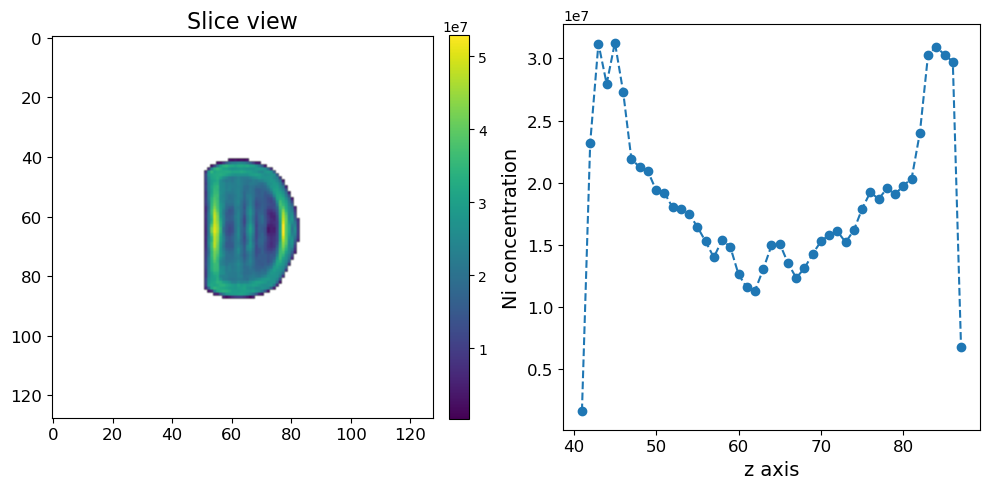

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
px, py, pz = obj.shape
im = ax1.imshow(np.abs(FA_amp_masked[px//2, :, :]))
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Slice view", fontsize=16)
ax1.tick_params(labelsize=12)

# Right subplot: line plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.abs(FA_amp_masked[px//2, :, pz//2]), "--o")
ax2.set_ylabel('Ni concentration', fontsize=14)
ax2.set_xlabel('z axis', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


In [42]:
def center_crop(array, new_shape):
    """
    Crop a N‑D numpy array to new_shape by removing equally from front and back.
    array.shape must be ≥ new_shape in every dimension.
    """
    old_shape = array.shape
    if len(old_shape) != len(new_shape):
        raise ValueError("array and new_shape must have same number of dimensions")
    slices = []
    for old, new in zip(old_shape, new_shape):
        if new > old:
            raise ValueError(f"cannot crop dimension {old} down to {new}")
        delta = old - new
        start = delta // 2
        stop = start + new
        slices.append(slice(start, stop))
    return array[tuple(slices)]

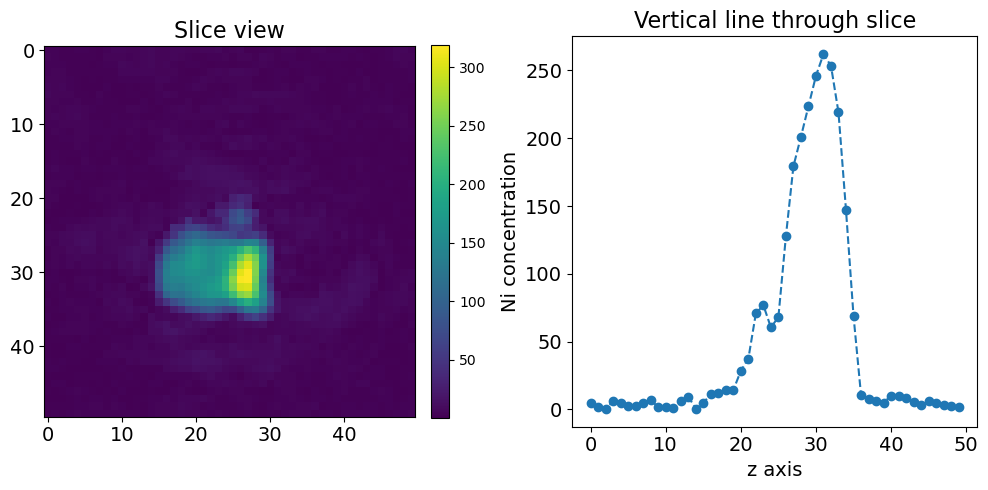

In [28]:
target = (99, 50, 50)
obj_cropped = center_crop(obj, target)
px, py, pz = obj_cropped.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
px, py, pz = obj_cropped.shape
im = ax1.imshow(np.abs(obj_cropped[px//2, :, :]))
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Slice view", fontsize=16)
ax1.tick_params(labelsize=14)

# Right subplot: line plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.abs(obj_cropped[px//2, :, pz//2]), "--o")
ax2.set_ylabel('Ni concentration', fontsize=14)
ax2.set_xlabel('z axis', fontsize=14)
ax2.set_title("Vertical line through slice", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

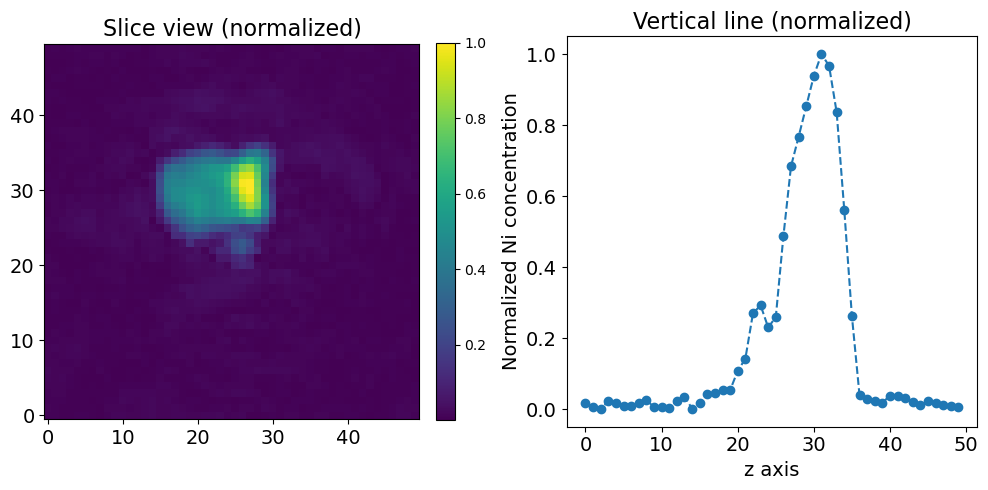

In [29]:
# 2) Pull out and normalize the slice
slice2d = np.abs(obj_cropped[px//2, :, :])
slice2d_norm = slice2d / slice2d.max()

# 3) Pull out and normalize the line profile
profile = np.abs(obj_cropped[px//2, :, pz//2])
profile_norm = profile / profile.max()

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left subplot: normalized slice
ax1 = axes[0]
im = ax1.imshow(slice2d_norm,
                origin='lower',
                interpolation='nearest',
                cmap='viridis')
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Slice view (normalized)", fontsize=16)
ax1.tick_params(labelsize=14)

# Right subplot: normalized profile
ax2 = axes[1]
ax2.plot(profile_norm, "--o")
ax2.set_title("Vertical line (normalized)", fontsize=16)
ax2.set_xlabel('z axis', fontsize=14)
ax2.set_ylabel('Normalized Ni concentration', fontsize=14)
ax2.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [30]:
# # 1) choose your output directory & filename
# out_dir  = "/data/id01/inhouse/tsarrazin/Concentration/blc16220_16242/arrays/nanomad_results"
# out_file = "retrieved_NMAD_FA_16242_cropped_amp.npy"
# os.makedirs(out_dir, exist_ok=True)
# save_path = os.path.join(out_dir, out_file)

# # 2) save as a .npy
# np.save(save_path, obj_cropped)
# print(f"✅ Saved obj_cropped to {save_path}")

✅ Saved obj_cropped to /data/id01/inhouse/tsarrazin/Concentration/blc16220_16242/arrays/nanomad_results/retrieved_NMAD_FA_16242_cropped_amp.npy


TypeError: unwrap_phase() got an unexpected keyword argument 'seed'

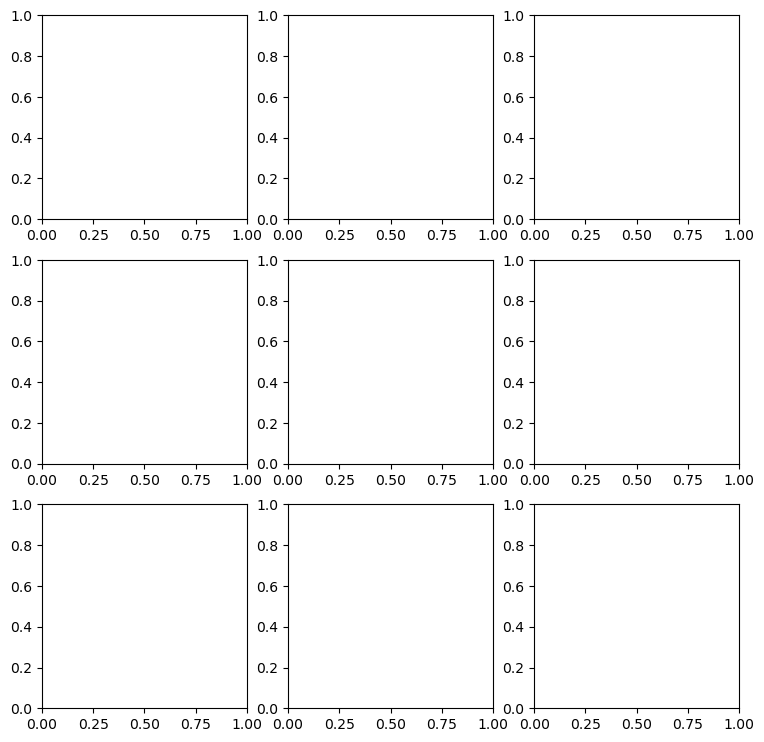

In [31]:
plot_2D_slices_middle_and_histogram(obj)

### Test one reconstruction

In [ ]:
crop_factor_list = [1.5]# Careful not to crop too much for the first reconstruction
data_centering = False
mask_used = None

obj, llk, support, return_dict = crop_scale_function(data_new, 
                                        crop_factor_list = crop_factor_list, 
                                        params=None, # default reconstruction parameters
                                        plot=True, verbose=True,
                                                     mask=mask_used,
                                                    data_centering=data_centering)

In [ ]:
plot_2D_slices_middle(obj)

In [ ]:
# %pwd
# #np.savez_compressed("/data/projects/carine/richard/Experiment2024/P10_June24/S191_orthonormalised_new", obj=obj, support=support, llk=llk)

# data = np.load("/data/projects/carine/richard/Experiment2024/P10_June24/S191_orthonormalised_new.npz")
# obj = data['obj']

In [ ]:
module_ortho = abs(obj)
phase_no_ramp = np.angle(obj)

nx,ny,nz = np.shape(module_ortho)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(module_ortho[nx//2,:,:])
plt.subplot(1,3,2)
plt.imshow(module_ortho[:,ny//2,:])
plt.subplot(1,3,3)
plt.imshow(module_ortho[:,:,nz//2])
plt.tight_layout()

In [ ]:
print(np.shape(module_ortho))
obj_ortho = obj

In [ ]:
obj_ortho = crop_array_symmetric(obj_ortho,(60,60,60) ,inverse_crop=True)

In [ ]:
plot_2D_slices_middle(obj_ortho)

### Take the complex conjugate

In [ ]:
#obj_new = np.conj(obj_ortho[::-1,::-1,::-1])

In [ ]:
#plot_2D_slices_middle(obj_new)

In [ ]:
print(np.shape(obj))
print(np.shape(obj_ortho))
voxel_sizes = [2*np.pi/(0.0003*200),2*np.pi/(0.0003*200),2*np.pi/(0.0003*200)]
print(voxel_sizes)

## Remove ramp

In [ ]:
phase_ramp_removal = True
threshold_module = 0.2
obj_no_ramp = remove_phase_ramp(obj_ortho,
                          threshold_module=threshold_module,
                          crop=False,
                          return_ramp=False,
                          plot=False)

In [ ]:
module_ortho, phase_ortho = get_cropped_module_phase(obj_no_ramp, crop=False, unwrap=True, threshold_module=threshold_module)

In [ ]:
plot_2D_slices_middle(obj_no_ramp)

## Plot in 3D

In [ ]:
ipv.quickvolshow(module_ortho/module_ortho.max(), level=[0.3], opacity=0.05, level_width=0.1, data_min=0, data_max=1)




# Show the plot
ipv.show()

In [ ]:
# module_ortho = module_ortho/np.max(module_ortho)
# np_arrays = {'module_ortho' : module_ortho,
#              'phase_ortho' : phase_ortho}
# save_vti(np_arrays, 
#              voxel_sizes, "/data/projects/carine/richard/Experiment2024/P10_June24/")

## Plot figures

In [ ]:
nx,ny,nz = np.shape(module_ortho)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(module_ortho[nx//2,:,:])
plt.xlabel('Z')
plt.ylabel('Y')
plt.subplot(1,3,2)
plt.imshow(module_ortho[:,ny//2,:])
plt.xlabel('Z')
plt.ylabel('X')
plt.subplot(1,3,3)
plt.imshow(module_ortho[:,:,nz//2])

plt.xlabel('Y')
plt.ylabel('X')
plt.tight_layout()